# Calorie Intake Prediction
#
## 1. Imports and Data Loading

In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold,cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
sns.color_palette("tab10",8)
daily_activity_merged = pd.read_csv("data/dailyActivity_merged.csv")
print(daily_activity_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

## 2. Data cleaning and Variable Selection

<Axes: title={'center': 'Correlation matrix of selected prediction variables'}>

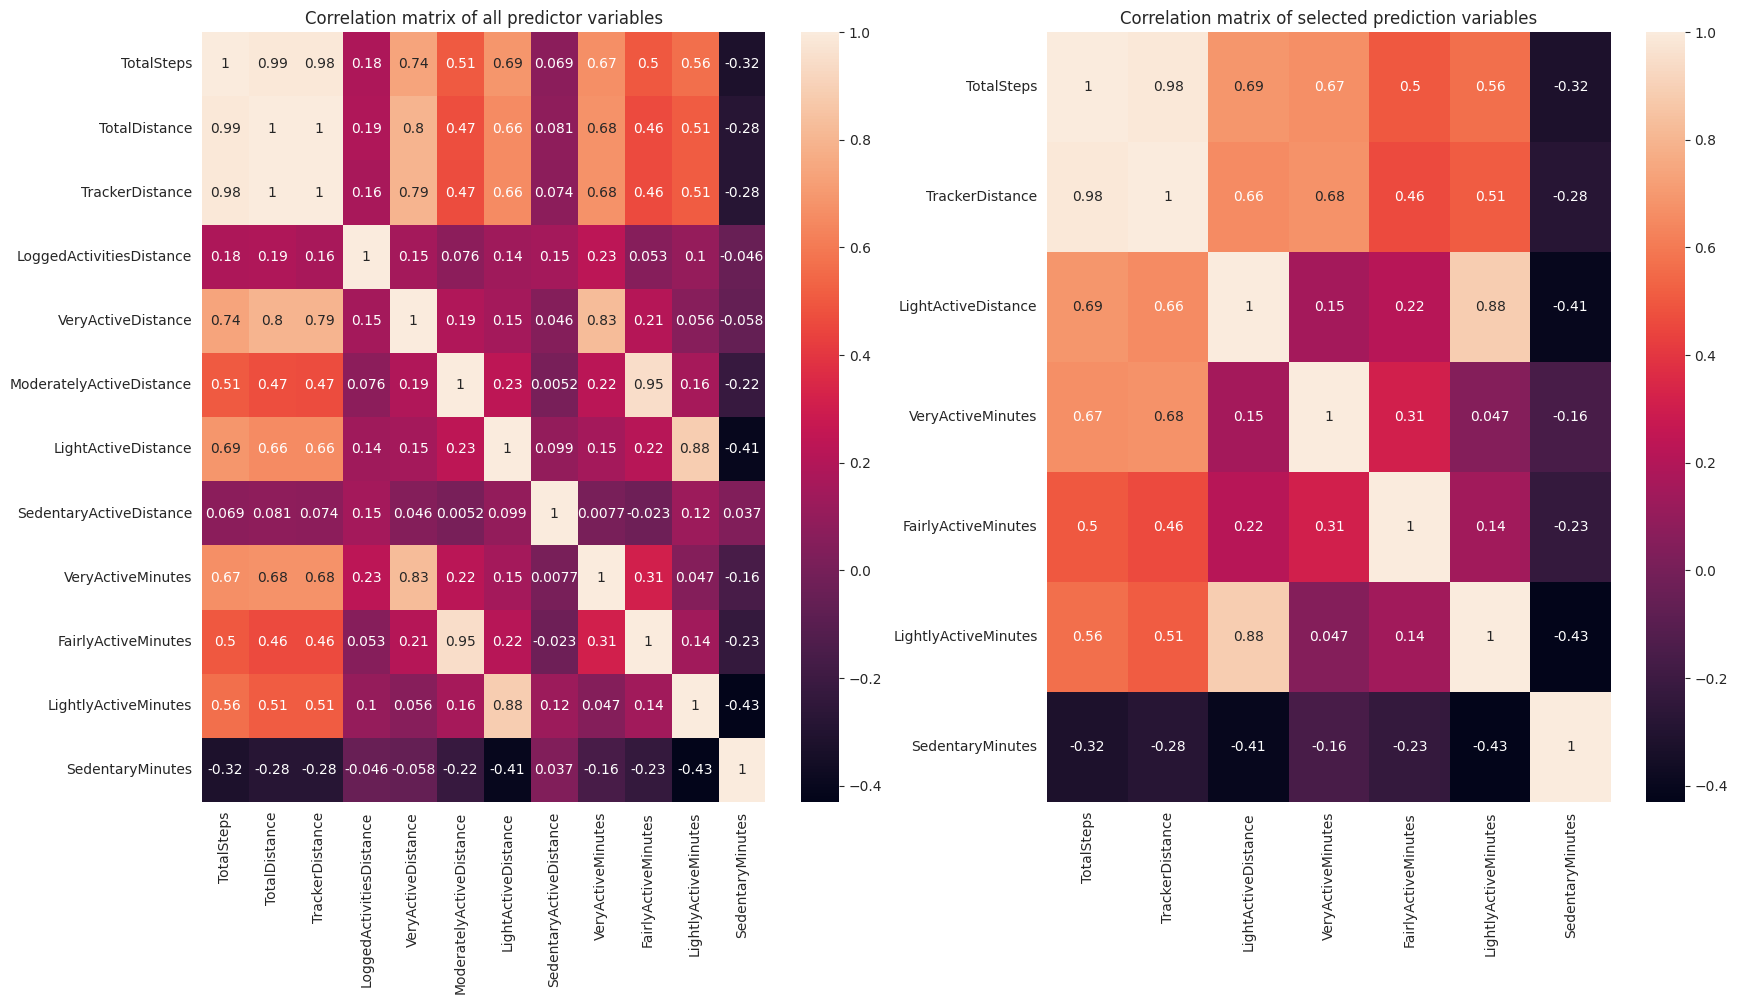

In [63]:
daily_activity_merged = daily_activity_merged.loc[daily_activity_merged["Calories"] > 0,:] # Avoid all zero values. Scaling issues you know
daily_activity_merged.drop(["Id","ActivityDate"],axis=1,inplace=True) # Not necessary for this analysis. Drop em

response_variable = daily_activity_merged.loc[:,["Calories"]] # This will be our target variable. Since we are making predictions about calories
predictor_variables = daily_activity_merged.loc[:,["TotalSteps","TrackerDistance","LightActiveDistance","VeryActiveMinutes","FairlyActiveMinutes","LightlyActiveMinutes","SedentaryMinutes"]] # Selecting uncorrelated variables


fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
axs[0].set_title("Correlation matrix of all predictor variables")
axs[1].set_title("Correlation matrix of selected prediction variables")
sns.heatmap(daily_activity_merged.iloc[:,:-1].corr(), ax = axs[0],annot=True)
sns.heatmap(predictor_variables.corr(),ax=axs[1],annot=True)


##
## 3. Data splits, Model definition and Model training

In [ ]:
kf = KFold(shuffle=True,random_state=7,n_splits=3) # 3 cross validation splits

estimator = Pipeline([("scaler",StandardScaler()),("polynomial_features",PolynomialFeatures()),("lasso_regression",Lasso())])
predictions = cross_val_predict(estimator,predictor_variables,response_variable, cv=kf)


In [ ]:
params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(4, 20, 30)
}
grid = GridSearchCV(estimator,params,cv=kf)
grid.fit(predictor_variables,response_variable)
print(grid.best_score_)

##
## 4. Performance Visualization

In [ ]:
y_predict = grid.predict(predictor_variables)

score = r2_score(response_variable,y_predict)